In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

## Background theory

A maximum entropy model is one that makes as little assumptions as possible while still fulfilling some constraints. These constraints are sometimes interpreted as features, but in practice they usually correspond to fixing [moments](https://en.wikipedia.org/wiki/Moment_(mathematics). That is, we seek a model of a distribution that has maximal entropy: 

$$
\begin{equation}
 H = - \sum_i p(x_i) \log \left( p(x_i) \right)
\end{equation}
$$

but that also has the same moments as our sample. This is achieved through the method of Lagrange multipliers, which maximizes a functional that depends on the constraints as:

$$
\begin{equation}
 \tilde{H} = - \sum_i p(x_i) \log ( p(x_i) ) + \lambda_0 ( ( \sum_i p(x_i) ) - 1 ) + \sum_k \lambda_k ( ( \sum_i p(x_i) f_k(x_i) ) - \sum_i p_\mathrm{emp.}(x_i) f_k(x_i) ).
\end{equation}
$$

where $( \sum_i p(x_i) ) - 1$ derives from all probabilities summing up to one and $\sum_i p(x_i) f_k(x_i) - \sum_i p_\mathrm{emp.}(x_i) f_k(x_i)$ from matching moments. The actual moment is given by $f$, and matching, for example, the mean thus corresponds to having $f(x)=x$. A maximum entropy model (distribution) can therefore be found by maximizing $\tilde{H}$ with respect to both $p$ and the $\lambda$s. This might seem complicated at first, but as the entropy function is convex and the constraints affine (in $p$), this is actually a convex optimization problem. The global optima can thus be found by setting the gradient to zero. For most cases, however, there is no closed form solution and numerical optimization routines are needed, but it is, nonetheless, possible to analytically derive the shape of $p$. 

The partial derivatives for each $p(x_i)$ is given by:

$$
\begin{equation}
 \frac{\partial \tilde{H}}{\partial p(x_i)} = - \log(p(x_i)) - 1 + \lambda_0 + \sum_k \lambda_k f_k(x_i),
\end{equation}
$$

and by setting these to zero, we learn that each $p(x_i)$ must have the form:

$$
\begin{align}
 0 &= - \log(p(x_i)) - 1 + \lambda_0 + \sum_k \lambda_k f_k(x_i), \\
 \log(p(x_i)) &= -1 + \lambda_0 + \sum_k \lambda_k f_x(x_i), \\
 p(x_i) &= \frac{\exp(\sum_k \lambda_k f_x(x_i))}{\exp(1-\lambda_0)}. \\
\end{align}
$$

The normalization constraint further corresponds to setting the partial derivative for $\lambda_0$ to zero:

$$
\begin{align}
 \frac{\partial \tilde{H}}{\partial \lambda_0} &= ( \sum_i p(x_i) ) - 1, \\
 0 &= ( \sum_i p(x_i) ) - 1, \\
 1 &= \sum_i p(x_i), \\
 1 &= \sum_i \frac{\exp(\sum_k \lambda_k f_x(x_i))}{\exp(1-\lambda_0)}, \\
 \exp(1-\lambda_0) &= \sum_i \exp(\sum_k \lambda_k f_x(x_i)).
\end{align}
$$

Thus, it follows that $p(x)$ can be described by:
$$
\begin{align}
 p(x_i) &= \frac{\exp(\sum_k \lambda_k f_x(x_i))}{Z}, \\
 Z &= \sum_i \exp \left( \sum_k \lambda_k f_x(x_i) \right),
\end{align}
$$

and that it belongs to the exponential family. The only parameters left to determine are then $\lambda_1, \ldots, \lambda_K$, which can be found by maximizing the constrained optimization problem $\tilde{H}$ directly or by maximizing a related unconstrained maximum likelihood problem (Berger et al., 1996). Given the empirical distribution $p_\mathrm{emp.}(x_i)$, the **mean** likelihood $L$ and mean log-likelihood $ll$ functions become:

$$
\begin{align}
 L &= \prod_i p(x_i|\lambda_1,\ldots,\lambda_K)^{p_\mathrm{emp.}(x_i)}, \\
 ll &= \sum_i p_\mathrm{emp.}(x_i) \log(p(x_i|\lambda_1,\ldots,\lambda_K)), \\
    &= \sum_i p_\mathrm{emp.}(x_i) \log(\exp(\sum_k \lambda_k f_x(x_i))) - \sum_i p_\mathrm{emp.}(x_i) \log(Z).
\end{align}
$$

The maximum of this log-likelihood function can be found using any gradient based method, and the expressions for the first and second partial derivative, respectively, are:

$$
\begin{align}
 \frac{\partial ll}{\partial \lambda_k} &= \sum_i p_\mathrm{emp.}(x_i) f_k(x_i) - \sum_i p_\mathrm{emp.}(x_i) \sum_j \frac{ \exp( \sum_k \lambda_k f_k(x_j))}{Z} f_k(x_j), \\
 &= \sum_i p_\mathrm{emp.}(x_i) f_k(x_i) - \sum_i p(x_i) f_k(x_i), \\
 &= \mathbb{E}_\mathrm{emp.}[f_k(x)] - \mathbb{E}[f_k(x)],\\
 \frac{\partial^2 ll}{\partial \lambda_k \partial \lambda_l} &= - (\mathbb{E}[f_k(x)f_l(x)] - \mathbb{E}[f_k(x)]\mathbb{E}[f_l(x)]).
\end{align}
$$

The expression for the first derivative neatly illustrates that the maximum likelihood approach yields $\lambda$s that constitute a solution to the original optimization problem $\tilde{H}$: the gradient will be zero when all the equality conditions are fulfilled. Similarly, the second derivatives extends upon this and further tells us that we do not just obtain a solution, but the optimal solution: Each second partial derivative occupies one element in the Hessian. Thus, we can conclude that the Hessian is the negative of a covariance matrix, and as covariance matrices are always positive semi-definite, the maximum found is guaranteed to be optimal and unique.

In the implementation below, we find maximum entropy models by solving the maximum likelihood problem using [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization). This method converges a lot faster than naive gradient descent, but it can become slow for large number of constraints as the inverse of the Hessian needs to be calculated at each step.

## Practical examples

#### Some functions

In [2]:
def generateResponsePatterns(outcomes, n_dims):
    """ Generate all possible response patterns """
    pattern_grid = np.meshgrid(*[outcomes for i in range(n_dims)], indexing='ij')
    patterns = np.vstack([grid_tmp.ravel() for grid_tmp in pattern_grid]).T
    
    return patterns

def generateModelTerms(patterns, order=1, var=True):
    """ Generate model terms from the response patterns 
    
        Indexes denote the response dimension (e.g., different cells)
        First order: f(x1,...,xk) = x1,...,xk
        Second order: f(x1,...,xk) = x1x1, x1x2,...,xkxk
    
    """
    n_dims = patterns.shape[1]
    
    # First order terms
    model_terms = patterns.copy()
    term_tags = []
    for i in range(n_dims):
        term_tags.append('x%1d' % (i+1))
        
    # Second order terms
    if order > 1:
        for i in range(n_dims):
            if var:
                start_idx = i
            else:
                start_idx = i+1  
            for j in range(start_idx, n_dims):
                tmp_term = patterns[:, i] * patterns[:, j]
                model_terms = np.append(model_terms, tmp_term[:, np.newaxis], axis=1)
                term_tags.append('x%1dx%1d' % (i+1, j+1))
                
    return model_terms, term_tags
             
def sampleDistribution(p, n_observations):
    """ Sample a 1 or 2 dimensional distribution """
    
    sample = -1 * np.ones([n_observations, len(p.shape)])
    
    if len(p.shape) == 1:
        p_cum = np.cumsum(p)
        r_sample = np.random.rand(n_observations)
        sample[:, 0] = np.array([np.argmax(r < p_cum) for r in r_sample])
        
    elif len(p.shape) == 2:
        # Cumulative distributions
        p_v1 = np.sum(p, axis=1)
        p_cum_v1 = np.cumsum(p_v1)
        p_v2_given_v1 = p / p_v1[:, np.newaxis]
        p_cum_v2_given_v1 = np.cumsum(p_v2_given_v1, axis=1)

        # Sample along each dimension separtely
        r_v1_sample = np.random.rand(n_observations)
        sample[:, 0] = np.array([np.argmax(r < p_cum_v1) for r in r_v1_sample])
        r_v2_sample = np.random.rand(n_observations)
        sample[:, 1] = np.array([np.argmax(r < p_cum_v2_given_v1[int(v1),:]) for r, v1 in zip(r_v2_sample, sample[:,0])])
        
    return sample
    
def getEmpiricalDistribution(sample, patterns):     
    """ Determine the empirical probability distribution"""        
    n_patterns = patterns.shape[0]
    pattern_counts = np.zeros(n_patterns)
    # Count how often each pattern occurs in the sample and normalize at the end
    for i in range(n_patterns):
        matches = np.where((sample == patterns[i, :]).all(axis=1))[0]
        pattern_counts[i] = matches.size
    p_emp = pattern_counts / pattern_counts.sum()
    
    return p_emp

def getModelDistribution(lambdas, model_terms):
    """ Determine the model's probability distribution"""
    p_model = np.exp(np.dot(model_terms, lambdas))
    p_model /= p_model.sum()
    
    return p_model

def logLikelihood(P_emp, p_model):
    """ Calculates the loglikelihood for current model parameters"""
    
    return np.dot(p_emp[p_model>0], np.log(p_model[p_model>0]))

def fitMaxEntropyModel(model_terms, p_emp, term_tags=[], verbose=1):
    """ Fit a maximum entropy model """

    # Exptectation values for each model term (constraints)
    E_emp = np.dot(p_emp, model_terms)
    
    # Initialize lambdas to zeros (initial guess)
    n_lambdas = model_terms.shape[1]
    lambdas = np.zeros(n_lambdas)
    
    # Get initial predicted probabilitites
    p_model = getModelDistribution(lambdas, model_terms)
    
    # Get the initial loglikelihood
    log_lik = []
    log_lik.append(logLikelihood(p_emp, p_model))
    
    # Gradient ascent with successive upated along the newton direction
    n_steps = 0
    converged = False
    while not converged:
        
        # Get the model's expectation values
        E_model = np.dot(p_model, model_terms)
        
        # Calculate the gradient and the Hessian
        gradient = E_emp - E_model
        h_term1 = np.dot(model_terms.T, (p_model[:, np.newaxis]*model_terms))
        h_term2 = np.outer(E_model, E_model)
        hessian = h_term1 - h_term2
        
        # Line search along the Newton direction
        newton_direction = np.dot(np.linalg.inv(hessian), gradient)
        step_lengths = np.arange(0.1, 1.01, 0.1)
        log_lik_tmp = np.zeros(step_lengths.size)
        for i in range(step_lengths.size):
            lambdas_tmp = lambdas + step_lengths[i]*newton_direction
            p_model_tmp = getModelDistribution(lambdas_tmp, model_terms)
            log_lik_tmp[i] = logLikelihood(p_emp, p_model_tmp)
        
        # Update lambdas using the best step length
        lambdas += step_lengths[log_lik_tmp.argmax()]*newton_direction
        
        # Model probabilitites with updated lambdas
        p_model = getModelDistribution(lambdas, model_terms)
        
        # Update the loglikelihood and check for convergence
        log_lik.append(logLikelihood(p_emp, p_model))
        if np.abs(log_lik[-1] - log_lik[-2]) < 1e-10:
            converged = True
        n_steps += 1
    
    if verbose:
        print('{:10}'.format('') + ''.join(['{:>8}'.format(tag) for tag in term_tags]))
        print('{:10}'.format('Empirical') + ''.join(['{:8.3f}'.format(val) for val in E_emp]))
        print('{:10}'.format('Model') + ''.join(['{:8.3f}'.format(val) for val in E_model]))
    
    return p_model, lambdas, log_lik

def naiveEntropy(p):
    """ Naive entropy calculation """
    
    return -np.sum(p[p>0]*np.log2(p[p>0]))

def plotModelFit(p_emp, p_model, x, log_lik):
    """ Plot Newton iterations and the fitted model"""

    # Open figure
    plt.figure(figsize=(15, 3))
    # Subplot 1
    ax = plt.subplot(1, 2, 1)
    ax.axhline(logLikelihood(p_emp, p_emp), c='gray', ls=':')  # Max value if p_emp == p_model
    ax.plot(np.arange(len(log_lik)), log_lik, 'ko')  # Progress per iteration
    ax.set_xlabel('Newton iteration step')
    ax.set_ylabel('Loglieklihood')
    # Subplot 2
    ax = plt.subplot(1, 2, 2)
    ax.bar(x, p_emp, alpha=0.4, label='$p_\mathrm{emp.}(x)$')
    ax.bar(x, p_model, color='r', alpha=0.4, label='$p_\mathrm{model}(x)$')
    ax.plot(x, p, 'ko', label='$p_\mathrm{true}(x)$')
    ax.legend(loc=0, frameon=False)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$');

#### Exponential distribution

                x1    x1x1
Empirical    2.385  12.935
Model        2.385  12.935


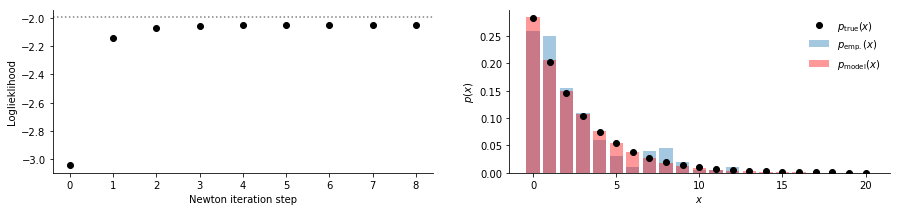

In [3]:
n_outcomes = 21
n_observations = 200
mu = 3.

# The true distribution is an exponential distribution
x = np.arange(n_outcomes)
p = 1/mu * np.exp(-x/mu)
p /= p.sum()

# Get a sample of n_observations from the true distribution
sample = sampleDistribution(p, n_observations)

# Get the response patterns and the model terms
patterns = generateResponsePatterns(x, sample.shape[1])
model_terms, term_tags = generateModelTerms(patterns, order=2)

# Empirical pattern probabilitites
p_emp = getEmpiricalDistribution(sample, patterns)

# Fit the maximum entropy model
p_model, lambdas, log_lik = fitMaxEntropyModel(model_terms, p_emp, term_tags)

# Plot results
plotModelFit(p_emp, p_model, x, log_lik)

#### Normal distribution

                x1    x1x1
Empirical    5.865  47.395
Model        5.865  47.395


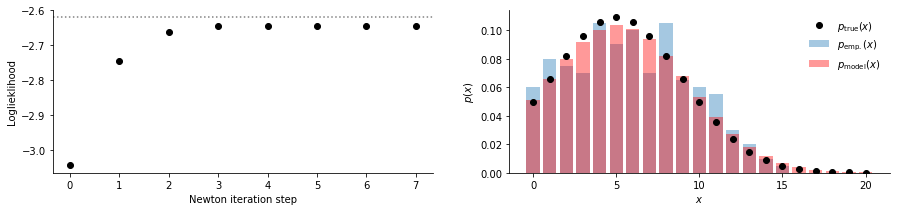

In [4]:
n_outcomes = 21
n_observations = 200
mu = 5.
sigma = 4.

# The true distribution is an normal distribution
x = np.arange(n_outcomes)
p = np.exp(-(x-mu)**2/(2*sigma**2))
p /= p.sum()

# Get a sample of n_observations from the true distribution
sample = sampleDistribution(p, n_observations)

# Get the response patterns and the model terms
patterns = generateResponsePatterns(x, sample.shape[1])
model_terms, term_tags = generateModelTerms(patterns, order=2)

# Empirical pattern probabilitites
p_emp = getEmpiricalDistribution(sample, patterns)

# Fit the maximum entropy model
p_model, lambdas, log_lik = fitMaxEntropyModel(model_terms, p_emp, term_tags)

# Plot results
plotModelFit(p_emp, p_model, x, log_lik)

#### Two-dimensional normal distribution

                x1      x2    x1x1    x1x2    x2x2
Empirical    9.922   9.929 115.475 110.682 115.330
Model        9.922   9.929 115.475 110.682 115.330


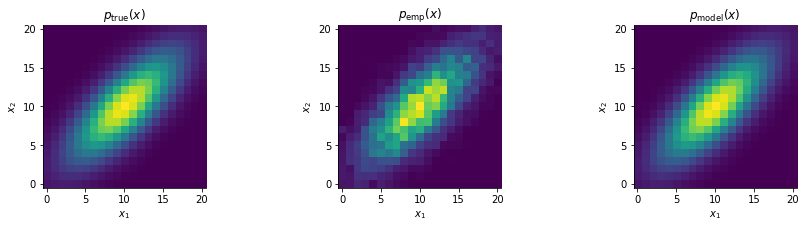

In [5]:
n_outcomes = 21
n_observations = 10000
mu = (n_outcomes-1) / 2.*np.ones([2, 1])
var = 20.
cov = 15.

# Get the true probability distribution
cov_mat = np.array([[var, cov], [cov, var]])
[x1, x2,] = np.meshgrid(range(n_outcomes), range(n_outcomes))
p = np.zeros([n_outcomes, n_outcomes])
for i in range(n_outcomes**2):
    x_tmp = np.array([x1.ravel()[i]-mu[0], x2.ravel()[i]-mu[1]])
    p.ravel()[i] = np.exp(-1/2 * np.dot(x_tmp.T, np.dot(np.linalg.inv(cov_mat), x_tmp)))
p /= p.sum()

# Get a sample of n_observations from the true distribution
sample = sampleDistribution(p, n_observations)

# Get the response patterns and the model terms
patterns = generateResponsePatterns(np.arange(n_outcomes), sample.shape[1])
model_terms, term_tags = generateModelTerms(patterns, order=2)

# Empirical pattern probabilitites
p_emp = getEmpiricalDistribution(sample, patterns)

# Fit the maximum entropy model
p_model, lambdas, log_lik = fitMaxEntropyModel(model_terms, p_emp, term_tags)

# Plot results
plt.figure(figsize=(15, 3))
# Subplot 1
ax = plt.subplot(1, 3, 1)
ax.imshow(p)
ax.invert_yaxis()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$p_\mathrm{true}(x)$')
# Subplot 2
ax = plt.subplot(1, 3, 2)
ax.imshow(p_emp.reshape(n_outcomes, n_outcomes))
ax.invert_yaxis()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$p_\mathrm{emp}(x)$')
# Subplot 3
ax = plt.subplot(1, 3, 3)
ax.imshow(p_model.reshape(n_outcomes, n_outcomes))
ax.invert_yaxis()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('$p_\mathrm{model}(x)$');

#### Entropy for two-dimensional normal distribution

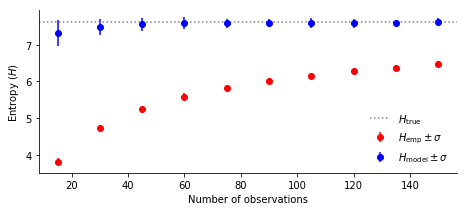

In [6]:
relevance_lim = 1e-2
n_dist_params = np.sum(p>relevance_lim)
sample_sizes = np.arange(1, 11)*n_dist_params
n_repetitions = 100

# Entropies
H_true = naiveEntropy(p)
H_emp = np.zeros([n_repetitions, sample_sizes.size])
H_model = np.zeros([n_repetitions, sample_sizes.size])

# Get the response patterns and the model terms
patterns = generateResponsePatterns(np.arange(n_outcomes), sample.shape[1])
model_terms, term_tags = generateModelTerms(patterns, order=2)

for size_idx in range(sample_sizes.size):
    
    n_observations = sample_sizes[size_idx]
    for rep_idx in range(n_repetitions):
        
        # Get a sample of n_observations from the true distribution
        sample = sampleDistribution(p, n_observations)

        # Empirical pattern probabilitites
        p_emp = getEmpiricalDistribution(sample, patterns)
        H_emp[rep_idx, size_idx] = naiveEntropy(p_emp)

        # Fit the maximum entropy model
        p_model, lambdas, log_lik = fitMaxEntropyModel(model_terms, p_emp, term_tags, verbose=0)
        H_model[rep_idx, size_idx] = naiveEntropy(p_model)
    
# Plotting
plt.figure(figsize=(7.5, 3))
plt.errorbar(sample_sizes, H_emp.mean(axis=0), yerr=H_emp.std(axis=0), fmt='ro', label='$H_\mathrm{emp}\pm\sigma$')
plt.errorbar(sample_sizes, H_model.mean(axis=0), yerr=H_model.std(axis=0), fmt='bo', label='$H_\mathrm{model}\pm\sigma$')
plt.axhline(H_true, ls=':', c='gray', label='$H_\mathrm{true}$')
plt.legend(loc=4, frameon=False)
plt.xlabel('Number of observations')
plt.ylabel('Entropy ($H$)');


#### Three dimensional binary distribution

In [75]:
def fitMaxEntropyModelE(model_terms, E_emp, term_tags=[], verbose=1):
    """ Fit a maximum entropy model """
    
    # Initialize lambdas to zeros (initial guess)
    n_lambdas = model_terms.shape[1]
    lambdas = np.zeros(n_lambdas)
    
    # Get initial predicted probabilitites
    p_model = getModelDistribution(lambdas, model_terms)
    
    # Get the initial loglikelihood
    log_lik = []
    log_lik.append(logLikelihood(p_emp, p_model))
    
    # Gradient ascent with successive upated along the newton direction
    n_steps = 0
    converged = False
    while not converged:
        
        # Get the model's expectation values
        E_model = np.dot(p_model, model_terms)
        
        # Calculate the gradient and the Hessian
        gradient = E_emp - E_model
        h_term1 = np.dot(model_terms.T, (p_model[:, np.newaxis]*model_terms))
        h_term2 = np.outer(E_model, E_model)
        hessian = h_term1 - h_term2
        
        # Line search along the Newton direction
        newton_direction = np.dot(np.linalg.inv(hessian), gradient)
        step_lengths = np.arange(0.1, 1.01, 0.1)
        log_lik_tmp = np.zeros(step_lengths.size)
        for i in range(step_lengths.size):
            lambdas_tmp = lambdas + step_lengths[i]*newton_direction
            p_model_tmp = getModelDistribution(lambdas_tmp, model_terms)
            log_lik_tmp[i] = logLikelihood(p_emp, p_model_tmp)
        
        # Update lambdas using the best step length
        lambdas += step_lengths[log_lik_tmp.argmax()]*newton_direction
        
        # Model probabilitites with updated lambdas
        p_model = getModelDistribution(lambdas, model_terms)
        
        # Update the loglikelihood and check for convergence
        log_lik.append(logLikelihood(p_emp, p_model))
        if np.abs(log_lik[-1] - log_lik[-2]) < 1e-10:
            converged = True
        n_steps += 1
    
    if verbose:
        print('{:10}'.format('') + ''.join(['{:>8}'.format(tag) for tag in term_tags]))
        print('{:10}'.format('Empirical') + ''.join(['{:8.3f}'.format(val) for val in E_emp]))
        print('{:10}'.format('Model') + ''.join(['{:8.3f}'.format(val) for val in E_model]))
    
    return p_model, lambdas, log_lik

n_outcomes = 2
r1 = 0.3
r2 = 0.2
r3 = 0.4
r12 = 2.5*r1*r2
r13 = 0.2*r1*r3
r23 = 0.5*r2*r3
E_emp = np.array([r1, r2, r3, r12, r13, r23])

# Get the response patterns and the model terms
patterns = generateResponsePatterns(np.arange(n_outcomes), 3)
model_terms, term_tags = generateModelTerms(patterns, order=2, var=False)

# Fit the maximum entropy model
p_model, lambdas, log_lik = fitMaxEntropyModelE(model_terms, E_emp, term_tags)

E_model = np.dot(p_model, model_terms)
k3 = p_model[7] + 2*E_model[0]*E_model[1]*E_model[2] - E_model[0]*E_model[5] - E_model[1]*E_model[4] - E_model[2]*E_model[3]
print(k3)

                x1      x2      x3    x1x2    x1x3    x2x3
Empirical    0.300   0.200   0.400   0.150   0.024   0.040
Model        0.300   0.200   0.400   0.150   0.024   0.040
-0.016429743697223845


In [23]:
patterns

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [35]:
E_model = np.dot(p_model, model_terms)
E_model[3]-r1*r2

1.0020945878652654e-10

In [40]:
p_model[7] + 2*E_model[0]*E_model[1]*E_model[2] - E_model[0]*E_model[5] - E_model[1]*E_model[4] - E_model[2]*E_model[3]

-2.6020852139652106e-18

In [37]:
model_terms

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1]])